##Re_Code Python version of new method to obtain real free engergy surface 
####Reference http://pubs.acs.org/doi/pdfplus/10.1021/jp504920s

In [3]:
import numpy as np
from math import ceil, log, exp
import matplotlib.pyplot as plt
import scipy as scipy
from matplotlib.patches import Rectangle

###Input Parameters setting (Only have to change this part)

In [4]:
numdat=11 #number of fes files
kT=2.49  #Temp=293.15
gamma=9 #biasfactor
col_fe=2 # column of free energy in fes file
numCV=2 #number of CV
numcolv= 25003  #number of time in COLVAR file | wc colvnew
col_CV= 1 #first column of CV strat from 0
col_bias= 4 #column of metabias in COLVAR file strat from 0

#CV max min and ngrid
min_ss_core = [-np.pi, -np.pi]
max_ss_core = [np.pi, np.pi]
ngrid_ss_core = [89, 89]

###Calculate Time-dependent c(t) function

In [5]:
ebetac=[]
for i in range(numdat):
    fname='fes_%d.dat' % (i)
    data = np.loadtxt(fname)
    s1, s2 =0., 0.
    for p in data:
        exponent = -p[col_fe]/kT
        s1 += exp(exponent)
        s2 += exp(exponent/gamma)
    ebetac += s1 / s2,

coft=[kT*log(x) for x in ebetac]

###Free Energy surface setup

In [6]:
#Set up the grid surface

s_grid = [[]] * numCV

for i in range(numCV):
    ds=(max_ss_core[i] - min_ss_core[i])/(ngrid_ss_core[i]-1)
    s_grid[i]= [ min_ss_core[i] + n*ds for n in range(ngrid_ss_core[i])]


colvar = np.loadtxt('colvnew')

step = numcolv/numdat

colvlst=[]
for i in range(step,numcolv,step):
    colvlst.append(i)

if colvlst[-1] != numcolv:
    colvlst.append(numcolv)


datlst=[]
for i in range(1,numdat+1):
    datlst.append(i)

if len(datlst) != len(colvlst):
    datlst.append(datlst[-1])

###Go through the trajectory

In [7]:
for nx, i in enumerate(colvlst):
    #initialize square array
    fes = np.zeros(ngrid_ss_core)
    denom = 0.
    u = 0

    for row in colvar[:i]:
        u += 1
        #build the array of grid indeces locs corresponding to the point clossest to current point
        locs=[[]] *numCV
        for j in range(numCV):
            val = row[j+col_CV]
            diff = np.array([abs(gval -val) for gval in s_grid[j]])
            locs[j] = [diff.argmin()]
        indx = int(ceil(float(u)/float(i)*float(datlst[nx])))-1

        ebias=exp(float(row[col_bias])/kT)/ebetac[indx]
        fes[locs] += ebias
    denom += ebias

    np.seterr(all='ignore')
    fes /= denom
    fes = -kT*np.log(fes)

    fes -= np.min(fes)


    with open('out_fes_xy_%s' % (nx), 'w') as f:
        if numCV==3:
            for nz,z in enumerate(s_grid[2]):
                for ny,y in enumerate(s_grid[1]):
                    for nx,x in enumerate(s_grid[0]):
                        f.write('%20.12f %20.12f %20.12f %20.12f\n' % (x,y,z,fes[nx][ny][nz]))
                    f.write('\n')
        elif numCV==2:
            for ny,y in enumerate(s_grid[1]):
                for nx,x in enumerate(s_grid[0]):
                    f.write('%20.12f %20.12f %20.12f\n' % (x,y,fes[nx][ny]))
                f.write('\n')
        elif numCV==1:
            for nx,x in enumerate(s_grid[0]):
                f.write('%20.12f %20.12f\n' % (x,fes[nx]))
        f.close()


###The Free energy surface contourplot

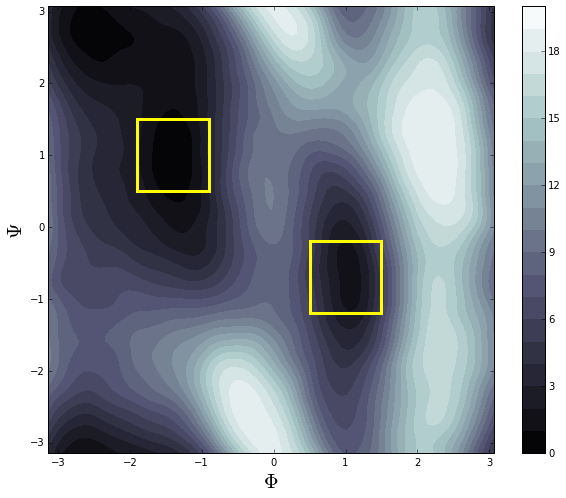

In [8]:
fesdata = np.genfromtxt('fes_10.dat')
%matplotlib inline 
fesdata=scipy.delete(fesdata, [3,4], 1)
dim = int(np.sqrt(np.size(fesdata)/3))
X=np.reshape(fesdata[:,0],[dim,dim], order = 'F')
Y=np.reshape(fesdata[:,1],[dim,dim], order = 'F')
Z=np.reshape((fesdata[:,2]-np.min(fesdata[:,2]))/4.184,[dim,dim],order="F")

spacer=1
lines=20
levels=np.linspace(0,lines*spacer,num=(lines+1),endpoint=True)


fig=plt.figure(figsize=(10,8)) 
axes = fig.add_subplot(111)
plt.xlabel('$\Phi$',fontsize=20)
plt.ylabel('$\Psi$',fontsize=20)

plt.contourf(X, Y, Z, levels, cmap=plt.cm.bone)
plt.colorbar()


## here is where you set the boxes to define convergence regions
C1=[-1.4,1] #center of box 1
C2=[1.0,-0.7]
edge1=1.0 #edge of box1 
edge2=1.0
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((C1[0]-edge1/2, C1[1]-edge1/2), edge1, edge1,facecolor='none',edgecolor='yellow',linewidth='3'))
currentAxis.add_patch(Rectangle((C2[0]-edge2/2, C2[1]-edge2/2), edge2, edge2,facecolor='none',edgecolor='yellow',linewidth='3'))


plt.show()

###Convergence test in two energy basins

In [9]:
T=293.15
kt= T*0.008314

#Define Basin 1 
x1=[-1.7,-1.1]
y1=[0.5,1]

#Define Basin 2
x2=[0.8,1.4]
y2=[-1,-0.4]

In [10]:
avg1=[]
avg2=[]
for i in range(0,numdat):
    data= np.loadtxt('out_fes_xy_%s' % (i))


    CV1=[row[0] for row in data]
    CV2=[row[1] for row in data]
    F=[row[2] for row in data]


    basin1=[]
    for i in range(len(CV1)):
        if CV1[i]> x1[0] and CV1[i]< x1[1] and CV2[i]> y1[0] and CV2[i]< y1[1]:
            p1= exp(float(-F[i])/kt)
            basin1.append(p1)


    basin2=[]
    for i in range(len(CV1)):
        if CV1[i]>x2[0] and CV1[i]<x2[1] and CV2[i]> y2[0] and CV2[i]< y2[1]:
            p2= exp(float(-F[i])/kt)
            basin2.append(p2)

    np.seterr(all='ignore')
    total1=sum(basin1)
    fes1= (-kt*np.log(total1))/4.18

    total2=sum(basin2)
    fes2= (-kt*np.log(total2))/4.18

    avg1.append(fes1)
    avg2.append(fes2)


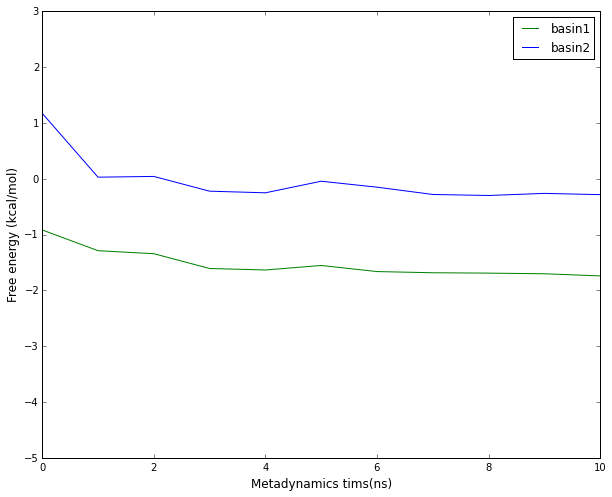

In [12]:
#plot free-energy as function as time



fig=plt.figure(figsize=(10,8)) 
axes = fig.add_subplot(111)

time= np.linspace(0,10,11)
plt.axis([0,10,-5,3])
axes.plot(time,avg1,'g', label = 'basin1')
axes.plot(time,avg2,'b', label = 'basin2')
plt.xlabel("Metadynamics tims(ns)",fontsize=12)
plt.ylabel("Free energy (kcal/mol)", fontsize=12)
plt.legend()
plt.show()



In [13]:
%%bash
rm -rf out_fes_xy_*